In [97]:
#!/bin/env python
# Add your own header comments
#

# This program is to create the visualization of: 1) annual stats metrics
                                                # 2) monthly stats metrics
# Name: Mukhamad Suhermanto
# email: msuherma@purdue.edu

In [98]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [99]:
def ReadData( fileName ):
    """This function takes a filename as input, and returns a dataframe with
    raw data read from that file in a Pandas DataFrame.  The DataFrame index
    should be the year, month and day of the observation.  DataFrame headers
    should be "agency_cd", "site_no", "Date", "Discharge", "Quality". The 
    "Date" column should be used as the DataFrame index. The pandas read_csv
    function will automatically replace missing values with np.NaN, but needs
    help identifying other flags used by the USGS to indicate no data is 
    availabiel.  Function returns the completed DataFrame, and a dictionary 
    designed to contain all missing value counts that is initialized with
    days missing between the first and last date of the file."""
    
    # define column names
    colNames = ['agency_cd', 'site_no', 'Date', 'Discharge', 'Quality']

    # open and read the file
    DataDF = pd.read_csv(fileName, header=1, names=colNames,  
                         delimiter=r"\s+",parse_dates=[2], comment='#',
                         na_values=['Eqp'])
    DataDF = DataDF.set_index('Date')
    
    #removing negative discharge values as gross error check
    DataDF=DataDF[~(DataDF['Discharge']<0)]
    
    # quantify the number of missing values
    MissingValues = DataDF["Discharge"].isna().sum()
    
    return( DataDF, MissingValues )

In [100]:
def ClipData( DataDF, startDate, endDate ):
    """This function clips the given time series dataframe to a given range 
    of dates. Function returns the clipped dataframe and and the number of 
    missing values."""
    
    # clipping the data for the range date parameters
    DataDF=DataDF[startDate:endDate]
    
    # quantifying the number of missing value
    MissingValues = DataDF["Discharge"].isna().sum()
      
    return( DataDF, MissingValues )

In [101]:
def ReadMetrics( fileName ):
    """This function takes a filename as input, and returns a dataframe with
    the metrics from the assignment on descriptive statistics and 
    environmental metrics.  Works for both annual and monthly metrics. 
    Date column should be used as the index for the new dataframe.  Function 
    returns the completed DataFrame."""
    
    # reading the file (csv format); taking 'Date' as the index; fileName will be used for both csv files
    DataDF = pd.read_csv(fileName, header=0, parse_dates=['Date'],delimiter=',', index_col=['Date'])
    # DataDF = DataDF.set_index('Date')
    
    return( DataDF )

In [102]:
def GetMonthlyStatistics(DataDF):
    """This function calculates monthly descriptive statistics and metrics 
    for the given streamflow time series.  Values are returned as a dataframe
    of monthly values for each year."""
 
    # resampling the data  
    MoDataDF = DataDF.resample('MS').mean()
    
    MoDataDF['site_no'] =  DataDF['site_no'][0]
    MoDataDF["Mean Flow"] = DataDF["Discharge"].resample('MS').mean()
    MoDataDF["Coeff Var"] = DataDF["Discharge"].resample('MS').std() / MoDataDF["Mean Flow"] * 100.
    MoDataDF["Tqmean"] = DataDF["Discharge"].resample('MS').apply(CalcTqmean)
    MoDataDF["R-B Index"] = DataDF["Discharge"].resample('MS').apply(CalcRBindex)

    return ( MoDataDF )

In [132]:
def GetMonthlyAverages(MoDataDF):
    """This function calculates annual average monthly values for all 
    statistics and metrics.  The routine returns an array of mean values 
    for each metric in the original dataframe."""
    
    # selecting months
    Months = MoDataDF.index.month
    
    # creating dataframe containing means 
    MonthlyAverages = MoDataDF.groupby(Months).mean()
    
    return( MonthlyAverages )

In [104]:
def annualPeakFlow(MoDataDF):
    """This function calculates annual peak flow ."""

    # rank values 
    DataRanks = sc.rankdata(MoDataDF, method='average')
    DataRanks = DataRanks[::-1]

    # length of MoDataDF
    len_DataDF = len(MoDataDF)

    # plotting position
    post = [(DataRanks[i] / (len_DataDF+1) ) for i in range(0, len_DataDF)]

    return( post )

In [105]:
def GetAnnualStatistics(DataDF):
    """This function calculates annual descriptive statistcs and metrics for 
    the given streamflow time series.  Values are retuned as a dataframe of
    annual values for each water year.  Water year, as defined by the USGS,
    starts on October 1."""
    
    # naming columns
    ColNames = ['site_no', 'Mean Flow', 'Peak Flow', 'Median  Flow', 'Coeff Var','Skew','Tqmean','R-B Index','7Q','3xMedian']  
   
    # resampling data of water year
    WYDataDF = DataDF.resample('AS-OCT').mean() 

    # storing annual metric values as a New dataframe
    WYDataDF = pd.DataFrame(0, index=WYDataDF.index,columns=ColNames) 

    WYDataDF['site_no'] =  DataDF['site_no'].mean()
    WYDataDF["Mean Flow"] = DataDF["Discharge"].mean()
    WYDataDF["Peak Flow"] = DataDF["Discharge"].max()
    WYDataDF["Median Flow"] = DataDF["Discharge"].median()
    WYDataDF["Coeff Var"] = DataDF["Discharge"].resample('AS-OCT').std() / WYDataDF["Mean Flow"] * 100.
    WYDataDF["Skew"] = DataDF["Discharge"].resample('AS-OCT').apply(stats.skew)
    WYDataDF["Tqmean"] = DataDF["Discharge"].resample('AS-OCT').apply(CalcTqmean)
    WYDataDF["R-B Index"] = DataDF["Discharge"].resample('AS-OCT').apply(CalcRBindex)
    WYDataDF["7Q"] = DataDF["Discharge"].resample('AS-OCT').apply(Calc7Q)
    WYDataDF["3xMedian"] = DataDF["Discharge"].resample('AS-OCT').apply(CalcExceed3TimesMedian)
    
    return ( WYDataDF )


In [108]:
def CalcTqmean(Qvalues):
    """This function computes the Tqmean of a series of data, typically
       a 1 year time series of streamflow, after filtering out NoData
       values.  Tqmean is the fraction of time that daily streamflow
       exceeds mean streamflow for each year. Tqmean is based on the
       duration rather than the volume of streamflow. The routine returns
       the Tqmean value for the given data array."""
    
    # dropping the NA value
    Qvalues = Qvalues.dropna()
    
    # computing Tqmean
    Tqmean = ((Qvalues > Qvalues.mean()).sum())/len(Qvalues)
    
    return ( Tqmean )

In [114]:
def CalcRBindex(Qvalues):
    """This function computes the Richards-Baker Flashiness Index
       (R-B Index) of an array of values, typically a 1 year time
       series of streamflow, after filtering out the NoData values.
       The index is calculated by dividing the sum of the absolute
       values of day-to-day changes in daily discharge volumes
       (pathlength) by total discharge volumes for each year. The
       routine returns the RBindex value for the given data array."""
    
    # dropping the NA value
    Qvalues = Qvalues.dropna()
    
    # summing of abs values
    Tsum = np.abs(Qvalues[:-1].values - Qvalues[1:].values).sum()
    
    # Dividing the sum 
    RBindex = (Tsum / Qvalues[1:].sum())    
        
    return ( RBindex )

In [124]:
if __name__ == '__main__':

    # define full river names as a dictionary so that abbreviations are not used in figures
    riverName = { "Wildcat": "Wildcat Creek",
                  "Tippe": "Tippecanoe River" }
    # directory for the USGS streamflow files for gauges Tippecanoe(1943 - 2020) and Wildcat Creek(1954-2020)
    fileName = { "Wildcat": "WildcatCreek_Discharge_03335000_19540601-20200315.txt",
                 "Tippe": "TippecanoeRiver_Discharge_03331500_19431001-20200315.txt" }
    
    # define blank dictionaries (these will use the same keys as fileName)
    DataDF = {}
    MissingValues = {}
    MoDataDF = {}
    MoAvg = {}
    
    # process input datasets
    for file in fileName.keys():
        # reading the data input
        DataDF[file], MissingValues[file] = ReadData(fileName[file])
        # Clipping the data to be used in the viz
        DataDF[file], MissingValues[file] = ClipData( DataDF[file], '1969-10-01', '2019-09-30' ) 
        # Monthly metrics
        MoDataDF[file] = GetMonthlyStatistics(DataDF[file])
        #annual average monthly values for all statistics and metrics
        MoAvg[file] = GetMonthlyAverages(MoDataDF[file])
        
    # Read the annual metric file created in Lab10 for Figure 3.2   
    Ann_Metr = ReadMetrics('Annual_Metrics.csv')     
    # Sort data of annual metrics by the station name
    Ann_Tipp = Ann_Metr[Ann_Metr['Station']=='Tippecanoe']
    Ann_WCat = Ann_Metr[Ann_Metr['Station']=='Wildcat']

/Users/cakherman/opt/anaconda3/envs/ABE651/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
/Users/cakherman/opt/anaconda3/envs/ABE651/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [116]:
for file in fileName.keys():
    
    print( "\n", "="*50, "\n  Working on {} \n".format(file), "="*50, "\n" )
    
    DataDF[file], MissingValues[file] = ReadData(fileName[file])
    print( "-"*50, "\n\nRaw data for {}...\n\n".format(file), DataDF[file].describe(), "\n\nMissing values: {}\n\n".format(MissingValues[file]))
    
    # clip to last 5 years
    DataDF[file], MissingValues[file] = ClipData( DataDF[file], '2014-10-01', '2019-09-30' )
    print( "-"*50, "\n\nSelected period data for {}...\n\n".format(file), DataDF[file].describe(), "\n\nMissing values: {}\n\n".format(MissingValues[file]))
    


  Working on Wildcat 

-------------------------------------------------- 

Raw data for Wildcat...

          site_no     Discharge
count    24030.0  23967.000000
mean   3335000.0    821.680131
std          0.0   1350.045050
min    3335000.0     46.000000
25%    3335000.0    183.000000
50%    3335000.0    382.000000
75%    3335000.0    840.000000
max    3335000.0  22100.000000 

Missing values: 63


-------------------------------------------------- 

Selected period data for Wildcat...

          site_no     Discharge
count     1826.0   1766.000000
mean   3335000.0   1036.964270
std          0.0   1336.960729
min    3335000.0     84.500000
25%    3335000.0    263.000000
50%    3335000.0    550.000000
75%    3335000.0   1217.500000
max    3335000.0  12600.000000 

Missing values: 60



  Working on Tippe 

-------------------------------------------------- 

Raw data for Tippe...

          site_no     Discharge
count    27926.0  27926.000000
mean   3331500.0    897.967020
std       

In [151]:
# Rank Calculation Process
# Dropping unused--> sorting --> Ranking (also reversing when necessary)
# drop all other colums from metric file to choose only Peak Flow column
WCat_drop = Ann_WCat.drop(columns=['site_no', 'Mean Flow', 'Median Flow', 'Coeff Var', 'Skew', 'Tqmean', 'R-B Index', '7Q', '3xMedian'])
Tippe_drop= Ann_Tipp.drop(columns=['site_no', 'Mean Flow', 'Median Flow', 'Coeff Var', 'Skew', 'Tqmean', 'R-B Index', '7Q', '3xMedian'])

WCatPeak_sort = WCat_drop.sort_values('Peak Flow', ascending=False)
TippePeak_sort = Tippe_drop.sort_values('Peak Flow', ascending=False)

WCatPeak_rank = stats.rankdata(WCatPeak_sort['Peak Flow'], method='average') 
TippePeak_rank= stats.rankdata(TippePeak_sort['Peak Flow'], method='average') 
WCat_rank = WCatPeak_rank[::-1]
Tippe_rank = TippePeak_rank[::-1]

#Plotting position calculation
WCat_ProbPost = [((WCat_rank[i]/(len(WCatPeak_sort)+1))) for i in range(len(WCatPeak_sort))]
Tippe_ProbPost  = [((Tippe_rank[i]/(len(TippePeak_sort)+1))) for i in range(len(TippePeak_sort))]


,Peak Flow,Median Flow,Station
Date,,,
1969-10-01,9410.0,0,Tippecanoe
1970-10-01,9410.0,0,Tippecanoe
1971-10-01,9410.0,0,Tippecanoe
1972-10-01,9410.0,0,Tippecanoe
1973-10-01,9410.0,0,Tippecanoe
1974-10-01,9410.0,0,Tippecanoe
1975-10-01,9410.0,0,Tippecanoe
1976-10-01,9410.0,0,Tippecanoe
1977-10-01,9410.0,0,Tippecanoe


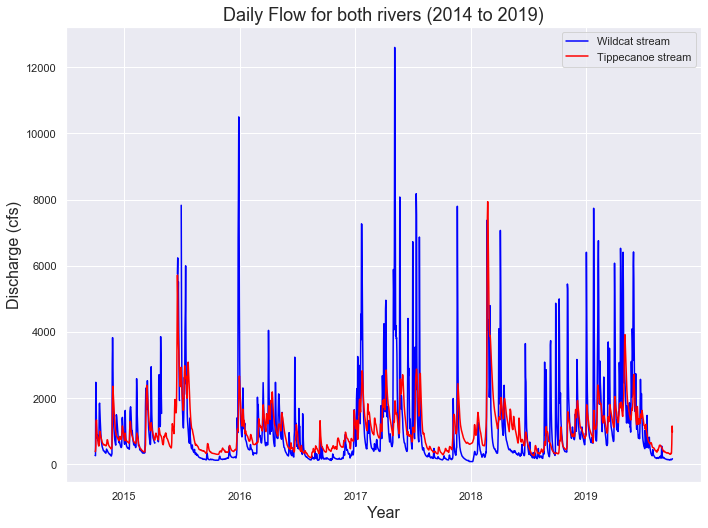

In [145]:
# Fig 1: Daily flow for both streams for the last 5 years of the record.
Wildcat_5y = DataDF['Wildcat']['2014-10-01' : '2019-09-30']
Tippe_5y = DataDF['Tippe']['2014-10-01' : '2019-09-30']

sns.set_style('darkgrid', rc={"grid.linewidth": 0.6})
sns.set_context("notebook", font_scale=1, rc={"grid.linewidth": 1})
plt.figure(figsize=(10,7.5)) 
plt.plot(Wildcat_5y['Discharge'], color='b', label= 'Wildcat stream')
plt.plot(Tippe_5y['Discharge'], color='r', label= 'Tippecanoe stream')
plt.legend(["Wildcat stream", "Tippecanoe stream"])
plt.xlabel('Year', size=16)
plt.ylabel('Discharge (cfs)', size=16)
plt.title('Daily Flow for both rivers (2014 to 2019)', size=18)
plt.tight_layout()
plt.savefig('DailyFlow_5yr.png', dpi=85) 
plt.show()

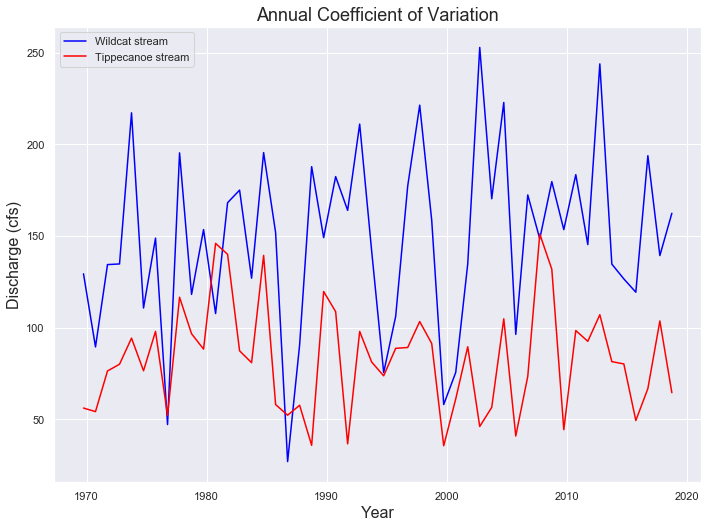

In [143]:
# Fig 2: Annual Coeff. of Variation of streamflow discharge (std.dev)

sns.set_style('darkgrid', rc={"grid.linewidth": 0.6})
sns.set_context("notebook", font_scale=1, rc={"grid.linewidth": 1})
plt.figure(figsize=(10,7.5)) 
plt.plot(Ann_WCat['Coeff Var'], color='b', label= 'Wildcat stream')
plt.plot(Ann_Tipp['Coeff Var'], color='r', label= 'Tippecanoe stream')
plt.legend(["Wildcat stream", "Tippecanoe stream"])
plt.xlabel('Year', size=16)
plt.ylabel('Discharge (cfs)', size=16)
plt.title('Annual Coefficient of Variation', size=18)
plt.tight_layout()
plt.savefig('COV_Annual.png', dpi=85) 
plt.show()

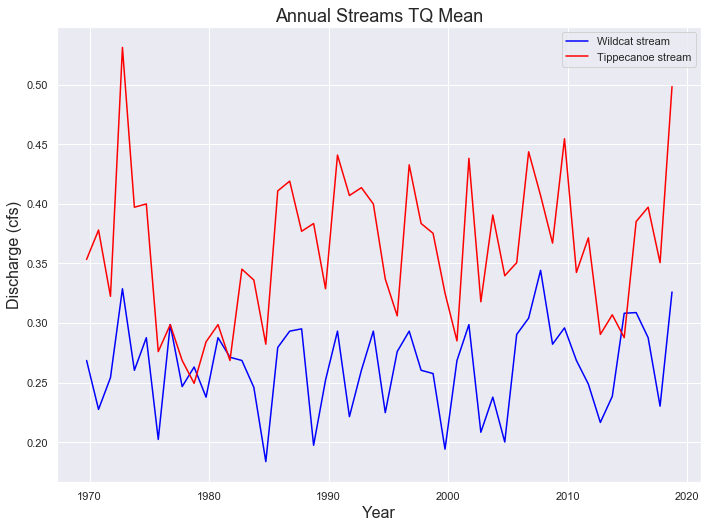

In [142]:
# Fig 3: Annual TQmean (fraction of time that daily streamflow exceeds mean streamflow for each year)
sns.set_style('darkgrid', rc={"grid.linewidth": 0.6})
sns.set_context("notebook", font_scale=1, rc={"grid.linewidth": 1})
plt.figure(figsize=(10,7.5)) 
plt.plot(Ann_WCat['Tqmean'], color='b', label= 'Wildcat stream')
plt.plot(Ann_Tipp['Tqmean'], color='r', label= 'Tippecanoe stream')
plt.legend(["Wildcat stream", "Tippecanoe stream"])
plt.xlabel('Year', size=16)
plt.ylabel('Discharge (cfs)', size=16)
plt.title('Annual Streams TQ Mean', size=18)
plt.tight_layout()
plt.savefig('Annual_Streams_TQmean.png', dpi=85) 
plt.show()

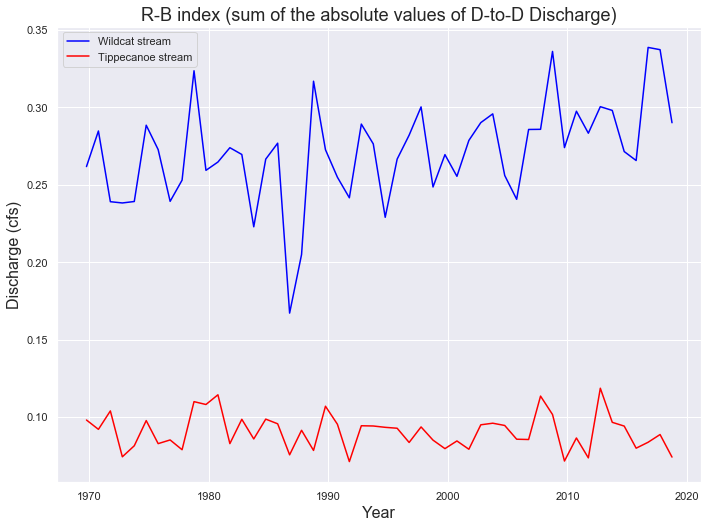

In [141]:
# Fig 4: R-B index (sum of the absolute values of day-to-day changes in daily discharge 
sns.set_style('darkgrid', rc={"grid.linewidth": 0.6})
sns.set_context("notebook", font_scale=1, rc={"grid.linewidth": 1})
plt.figure(figsize=(10,7.5)) 
plt.plot(Ann_WCat['R-B Index'], color='b', label= 'Wildcat stream')
plt.plot(Ann_Tipp['R-B Index'], color='r', label= 'Tippecanoe stream')
plt.legend(["Wildcat stream", "Tippecanoe stream"])
plt.xlabel('Year', size=16)
plt.ylabel('Discharge (cfs)', size=16)
plt.title('R-B index (sum of the absolute values of D-to-D Discharge)', size=18)
plt.tight_layout()
plt.savefig('RB_Index.png', dpi=85) 
plt.show()

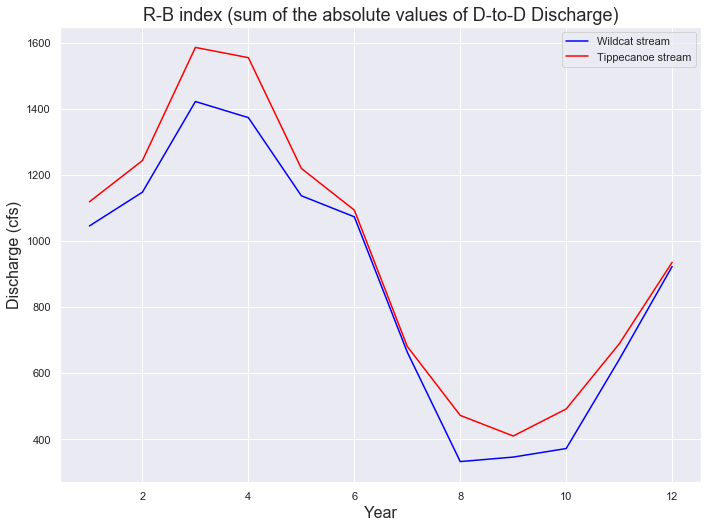

In [157]:

# Fig 5: Average annual monthly flow; using functions GetMonthlyStatistics and GetMonthlyAverages
sns.set_style('darkgrid', rc={"grid.linewidth": 0.6})
sns.set_context("notebook", font_scale=1, rc={"grid.linewidth": 1})
plt.figure(figsize=(10,7.5)) 
plt.plot(MoAvg['Wildcat']['Mean Flow'], color='b', label= 'Wildcat stream')
plt.plot(MoAvg['Tippe']['Mean Flow'], color='r', label= 'Tippecanoe stream')
plt.legend(["Wildcat stream", "Tippecanoe stream"])
plt.xlabel('Year', size=16)
plt.ylabel('Discharge (cfs)', size=16)
plt.title('R-B index (sum of the absolute values of D-to-D Discharge)', size=18)
plt.tight_layout()
plt.savefig('RB_Index.png', dpi=85) 
plt.show()

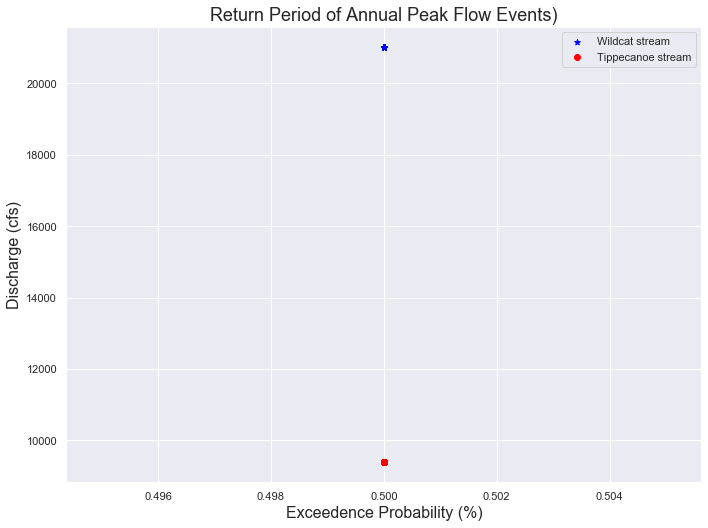

In [158]:
# Fig 6: Annual peak flow events
sns.set_style('darkgrid', rc={"grid.linewidth": 0.6})
sns.set_context("notebook", font_scale=1, rc={"grid.linewidth": 1})
plt.figure(figsize=(10,7.5)) 
plt.scatter(WCat_ProbPost, WCatPeak_sort['Peak Flow'], color='b', label= 'Wildcat stream',marker='*')
plt.scatter(Tippe_ProbPost, TippePeak_sort['Peak Flow'], color='r', label= 'Tippecanoe stream',marker='o')
ax= plt.gca()
plt.legend(["Wildcat stream", "Tippecanoe stream"])
plt.xlabel('Exceedence Probability (%)', size=16)
plt.ylabel('Discharge (cfs)', size=16)
plt.title('Return Period of Annual Peak Flow Events)', size=18)
plt.tight_layout()
plt.savefig('Return_Period_Ann_Events.png', dpi=85) 
plt.show()